# NORW January 1, 2022 to March 31, 2022

``nohup nextflow run sequencing_centre_trees.nf --start_date "2022-01-01" --end_date "2022-03-31" --diverseQueries false --centre "NORW" --max_samples_per_month false``

``
executor >  local (9)
[6a/dbb854] process > chooseSamples (1)        [100%] 1 of 1 ✔
[07/8fd7d8] process > getFastaRecords (1)      [100%] 1 of 1 ✔
[8f/5597d8] process > maskProblematicSites (1) [100%] 1 of 1 ✔
[58/19a75a] process > removeWuhanHu1 (1)       [100%] 1 of 1 ✔
[-        ] process > reduceQueries            -
[c6/cebf02] process > buildFastTree (1)        [100%] 1 of 1 ✔
[43/24151b] process > refineTree (1)           [100%] 1 of 1 ✔
[e4/970bde] process > runPangolin (1)          [100%] 1 of 1 ✔
[64/06ac2a] process > getCOGUKMetadata (1)     [100%] 1 of 1 ✔
[0c/f28520] process > joinMetadata (1)         [100%] 1 of 1 ✔
Completed at: 05-Apr-2022 16:15:06
Duration    : 3d 16h 27m 18s
CPU hours   : 154.1
Succeeded   : 9
``

This used ``cog_global_2022-03-28_public.csv.xz``.

# Setup

In [1]:
library(phangorn)
library(ggtreeExtra)
library(ggtree)
library(ggnewscale)
library(colorspace);
library(RColorBrewer);
library(dplyr)
library(tidyr)
library(ggplot2)
library (ggpubr)
library (stringr)
library(castor)
library(lubridate)

Loading required package: ape

code for methods in class “Rcpp_Fitch” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_Fitch” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

ggtreeExtra v1.4.1  For help: https://yulab-smu.top/treedata-book/

If you use ggtreeExtra in published research, please cite the paper:

S Xu, Z Dai, P Guo, X Fu, S Liu, L Zhou, W Tang, T Feng, M Chen, L Zhan, T Wu, E Hu, Y Jiang, X Bo, G Yu. ggtreeExtra: Compact visualization of richly annotated phylogenetic data. Molecular Biology and Evolution 2021, 38(9):4039-4042. doi: 10.1093/molbev/msab166



ggtree v3.2.1  For help: https://yulab-smu.top/treedata-book/

If you use ggtree in published research, please cite the most appropriate paper(s):

1. Guangchuang Yu. Using ggtree to visualize data on tree-like structures. Current Protocols in Bioinformatics. 2020, 69:e96. doi:10.1002/cpb

In [2]:
plot_tree_by_factor <- function(treefile, metadata, factor, treetype, mrsd){

# read in everything
#tbl0 <- read.csv (metadata, sep = ",") 
tbl0 <- meta
tbl0[is.na(tbl0)] <- ""
if(treetype=="tree") {tre <- treefile} #already read into ape
else if(treetype=="newick") {tre <- read.tree (treefile)}
else if (treetype=="nexus") {tre <- read.nexus (treefile)}
traits <- tbl0 %>% slice(match(tre$tip.label, sequence_name)) #this line means you could use the entire cog_uk metadata
rownames(traits) <- traits$sequence_name
# traits$code <- substr(traits$central_sample_id,1,4)

# get plot inputs
groupInfo <- split (tre$tip.label, traits[factor])
grouptre <- groupOTU(tre, groupInfo, group_name="group1")
options(repr.plot.width=26, repr.plot.height=20) ; par(oma=c(0,0,0,0)) 
my_lineages <- sort(unique(traits[["lineage"]])) 
plot_palette <- getPal_lineage[(intersect(names(getPal_lineage),my_lineages))]

# make plot
p <- ggtree (grouptre,  aes(color=group1),size=0.4, layout="rectangular", show.legend = FALSE) #, mrsd=mrsd)
p <- p + geom_tippoint(size=3, shape=21, aes(fill=group1))
p <- p + scale_color_manual(values = plot_palette, name="lineage") + scale_fill_manual(values = plot_palette, name="lineage")
p <- p + theme_tree2(text = element_text(size=50))
#p <- p + geom_treescale()
p <- p + theme(legend.position="left", legend.title = element_text(size=50), legend.text=element_text(size=50), legend.key.size = unit(1, 'cm'))
p
return(p)
}

In [3]:
treefile <- "reformatted.aln.treefile"
metadata_file <- "leaftips_cog_metadata.csv"

tre <- read.tree(treefile)
meta <- read.csv(metadata_file, sep=',')

In [4]:
meta$sequence_name <- str_replace_all(meta$sequence_name, '/', '_')
meta$sequence_name <- paste0("_", meta$sequence_name, "_")

meta <- meta %>% mutate(sample_date=as.POSIXct(sample_date))
meta$date2 <- as.Date(cut(meta$sample_date, breaks = "1 weeks", start.on.monday = TRUE))

meta$sample_date <- as.Date(meta$sample_date)
meta$code = substr(meta$central_sample_id,1,4)

meta$lineage <- str_replace_all(meta$lineage, 'AY.*', 'Delta')
meta$lineage <- str_replace_all(meta$lineage, 'B.1.617.2', 'Delta')

In [5]:
unique_lineages <- sort(unique(meta[["lineage"]]))
getPal_lineage = colorRampPalette(brewer.pal(8,"Dark2"))(length(unique_lineages) + 1)  ## RdYlGn Set2
names(getPal_lineage) = unique_lineages

# ML Tree

[1] "4560 tips"


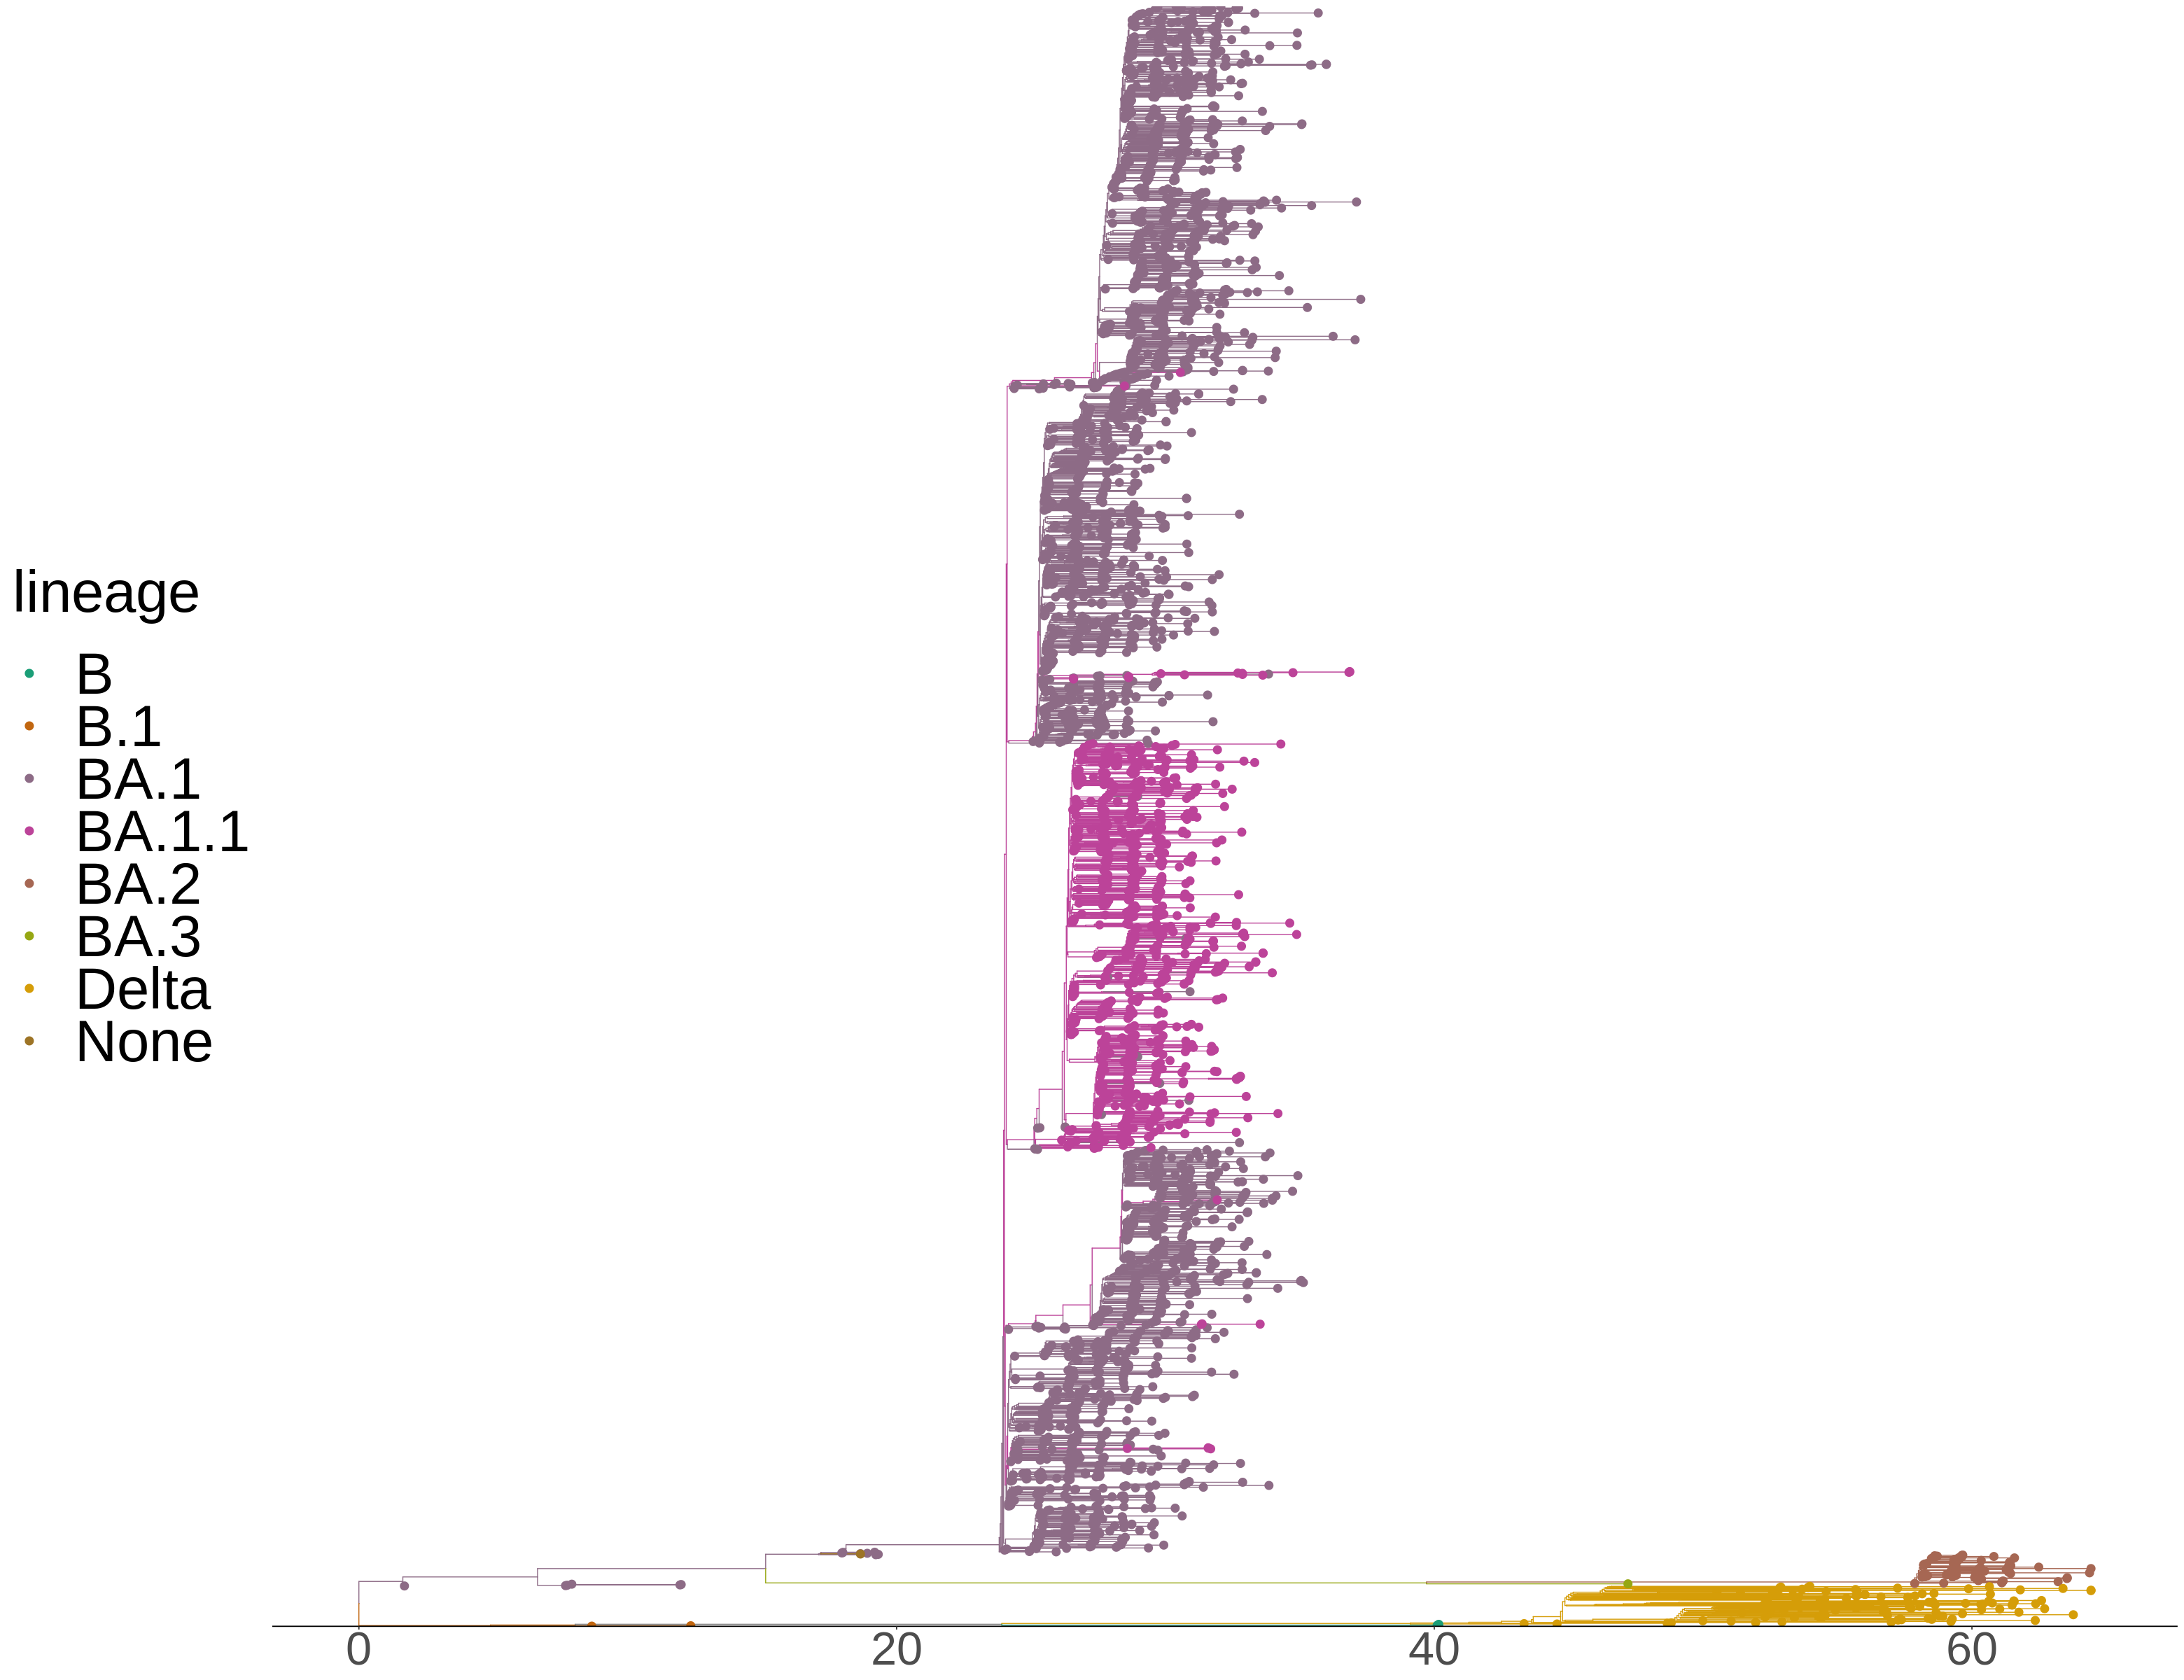

In [6]:
print(paste0(Ntip(tre), " tips"))

tre <- midpoint(tre) #reroot
tre$edge.length <- tre$edge.length * 29903 #rescale to expected number of snps

plot_tree_by_factor(tre, metadata_file, "lineage", "tree", "2022-03-31")

# Outlier detection

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



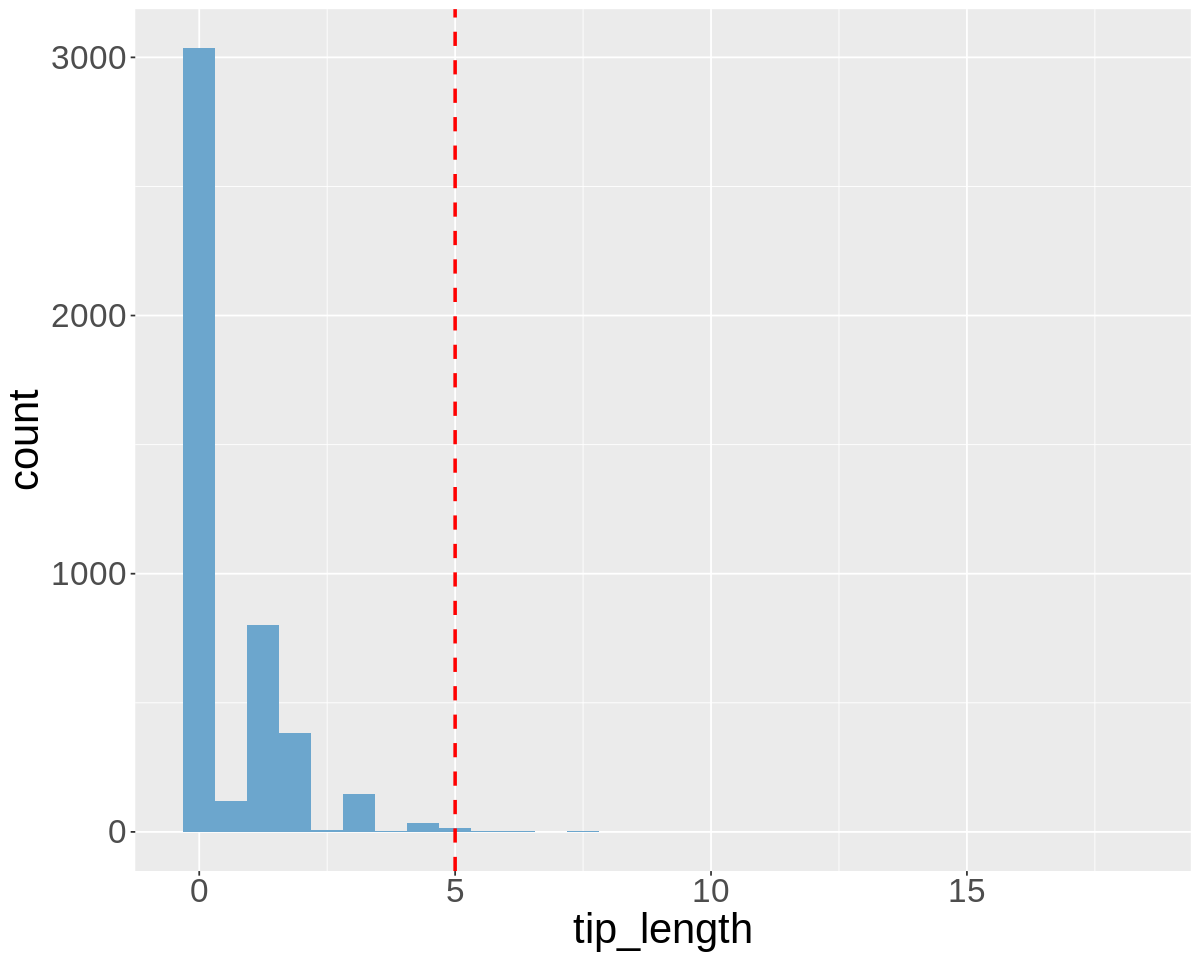

In [7]:
thresh = 5

tiplengths <- data.frame(tre$edge.length[1:Ntip(tre)])
names(tiplengths)[names(tiplengths) == 'tre.edge.length.1.Ntip.tre..'] <- 'tip_length'

options(repr.plot.width=10, repr.plot.height=8) ; par(oma=c(0,0,0,0)) 
p <- ggplot(tiplengths, aes(x=tip_length)) + geom_histogram(fill='skyblue3') + theme(text = element_text(size=25))
p <- p + geom_vline(xintercept = thresh, linetype = "dashed", colour = "red", size=1)
p

To remove all tips >= 5 SNPs:

[1] 27

[1] 4533

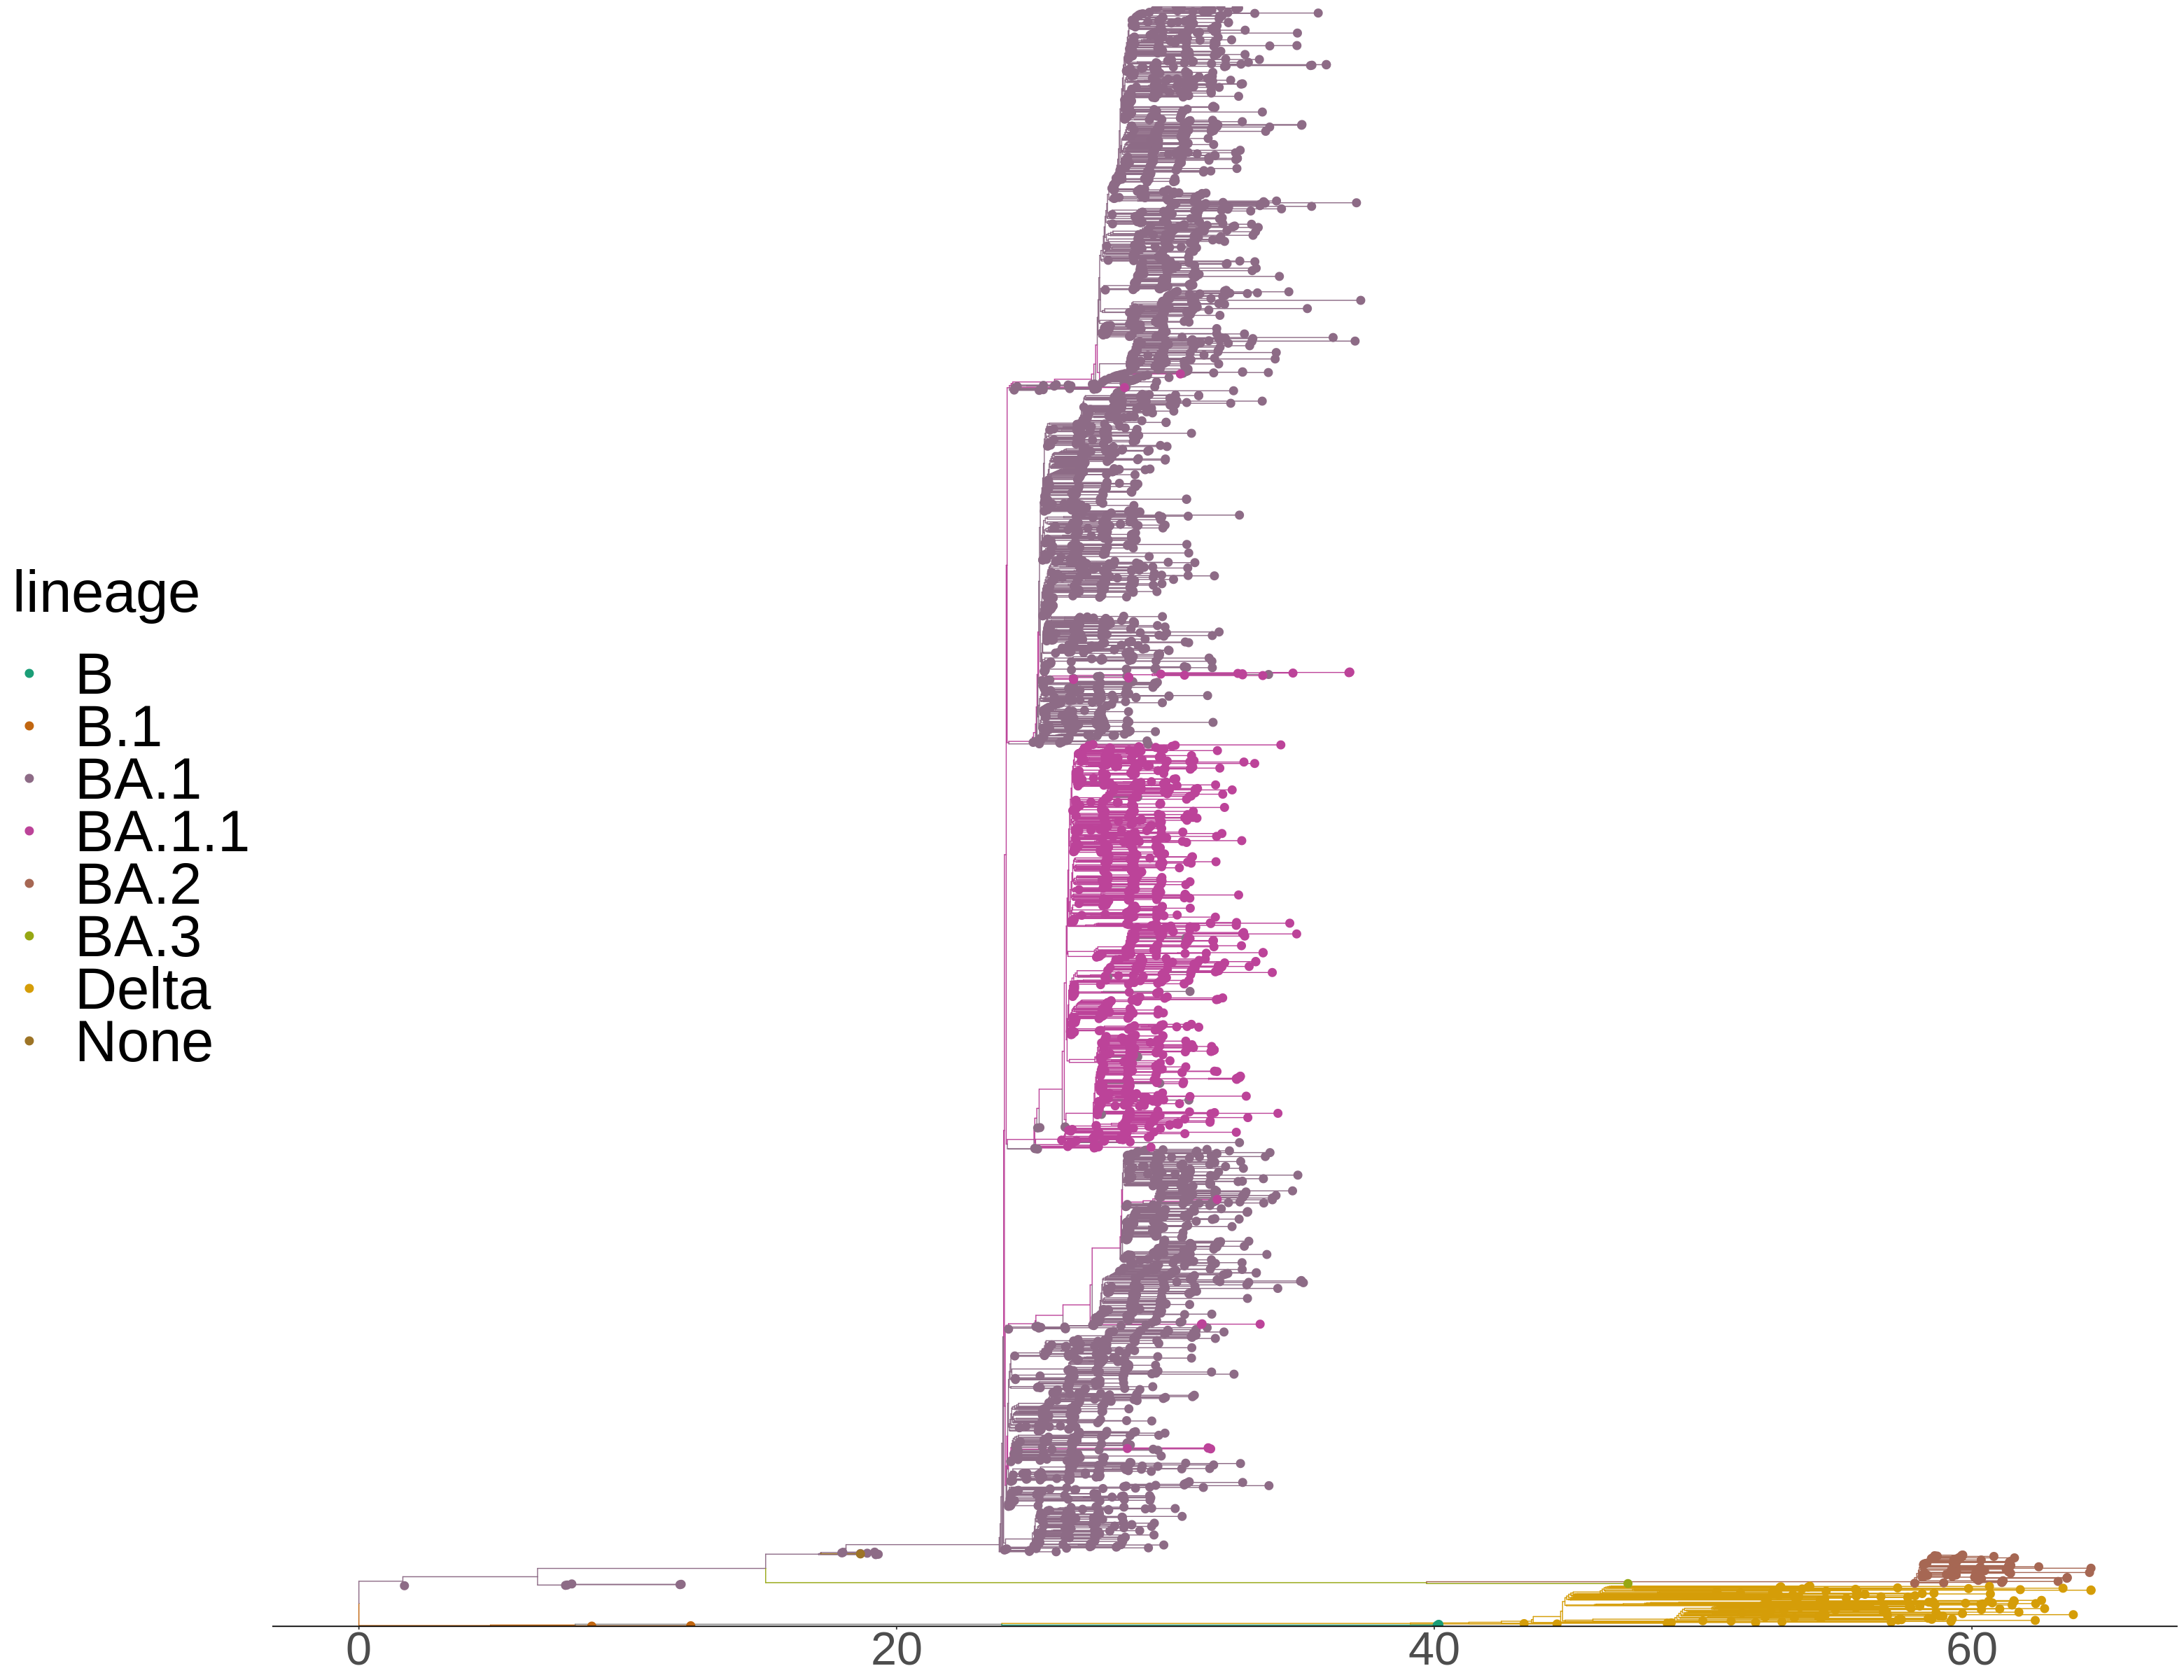

In [8]:
drop_tips <- tre$tip.label[(tre$edge.length[1:Ntip(tre)]) >= 5]
length(drop_tips)

trimmed_tre <- drop.tip(tre, drop_tips)
Ntip(trimmed_tre)

plot_tree_by_factor(trimmed_tre, metadata_file, "lineage", "tree", "2022-03-31")

# Sequence counts over time

[1] "NORW total seqs: 4560"


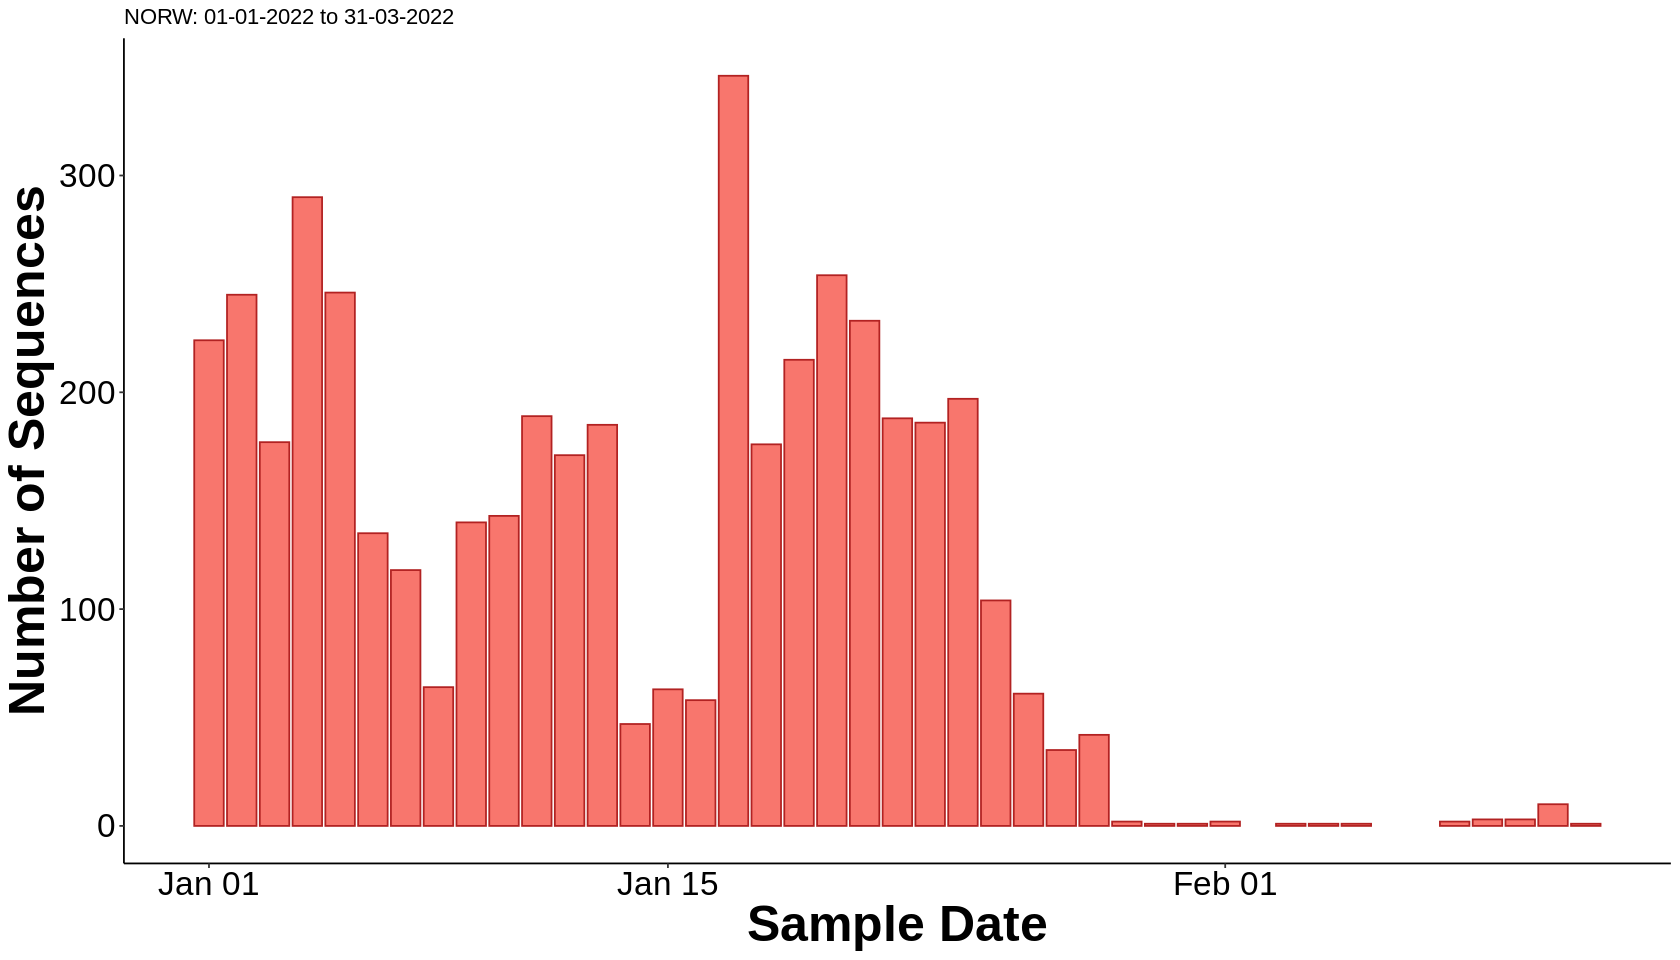

In [9]:
options(repr.plot.width=14, repr.plot.height=8) ; par(oma=c(0,0,0,0))

print(paste0("NORW total seqs: ", nrow(meta))) 
p <- ggplot(meta, aes(x = sample_date, fill='firebrick'), show.legend = FALSE) + geom_bar(color='firebrick', show.legend = FALSE)
p <- p + theme_classic() + theme(axis.text.x = element_text(color="black", size=16)) + xlab("Sample Date") + ylab("Number of Sequences")
p <- p + theme(axis.title.x = element_text(color="black", size=30, face="bold"), 
               axis.text.x = element_text(color="black", size=20),
               axis.title.y = element_text(color="black", size=30, face="bold"),
               axis.text.y = element_text(color="black", size=20),
               legend.text = element_text(size=16), legend.title = element_text(size=20)
              )

p <- p + labs(title = paste0("NORW: 01-01-2022 to 31-03-2022"))
p

# Lineages present

[1] "8 unique lineages"


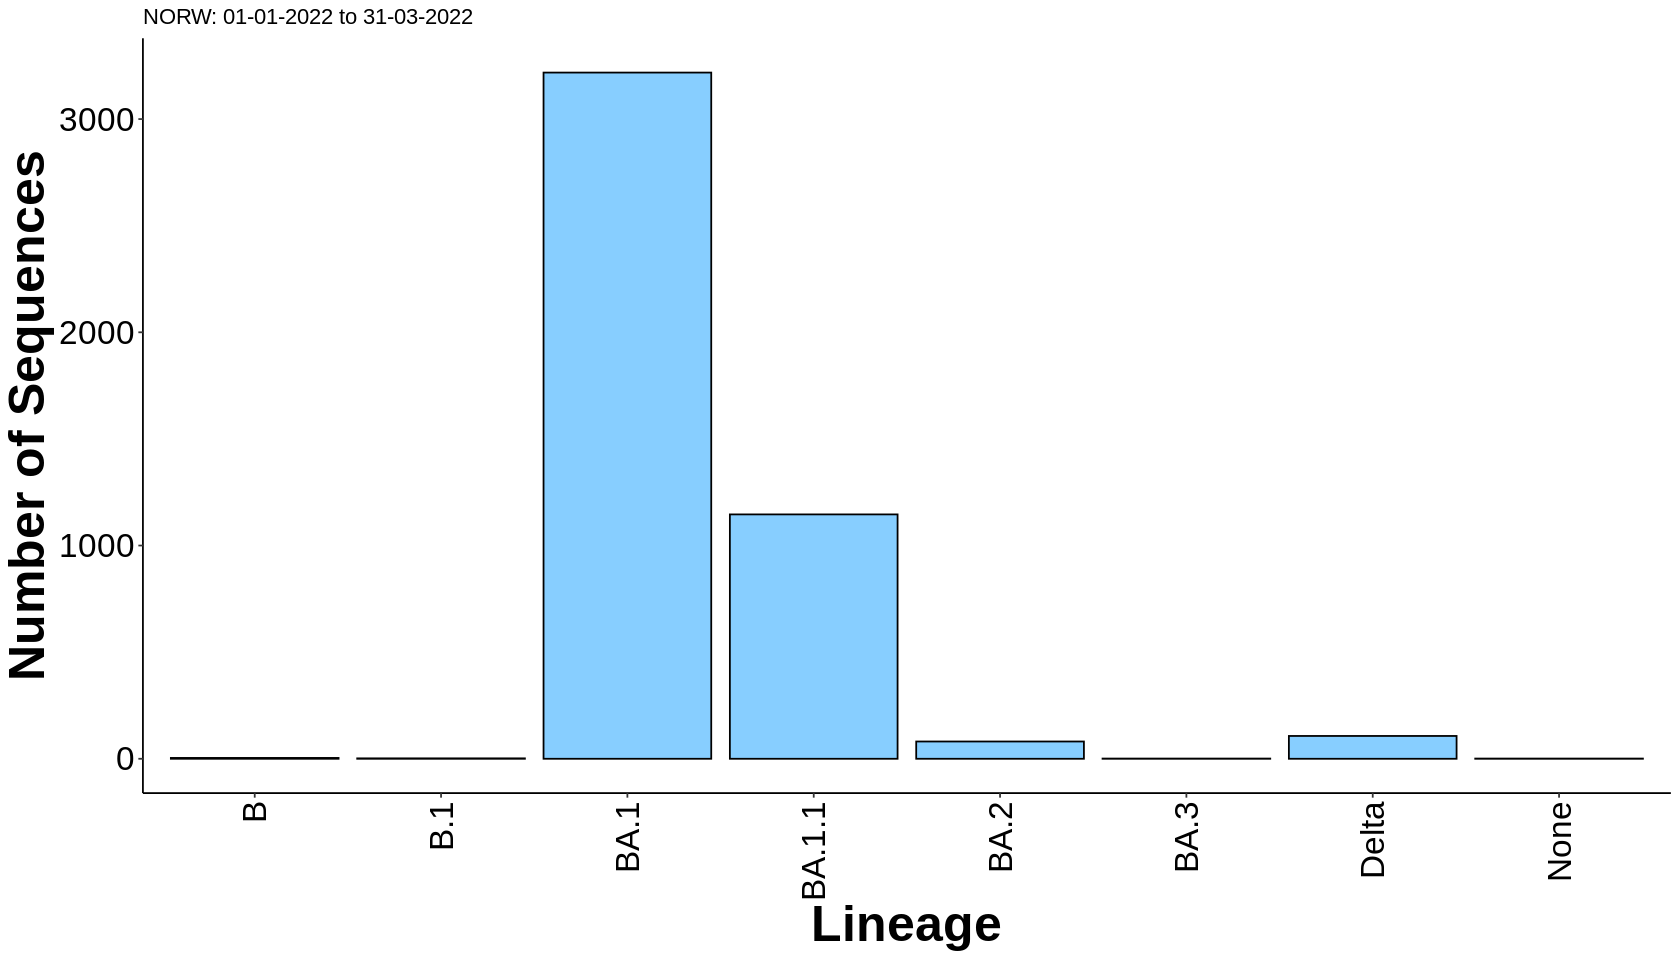

In [10]:
traits <- meta %>% slice(match(tre$tip.label, sequence_name)) #this line means you could use the entire cog_uk metadata
rownames(traits) <- traits$sequence_name
# traits$code <- substr(traits$central_sample_id,1,4)

total_lineages <- as.data.frame(table(meta$lineage))

num_uniq = length(unique(meta$lineage))
print(paste0(num_uniq, " unique lineages"))    

    
options(repr.plot.width=14, repr.plot.height=8) ; par(oma=c(0,0,0,0))
p <- ggplot(data=total_lineages, mapping = aes(x = Var1, y = Freq)) + ggplot2::geom_bar(stat="identity", color='black', fill='skyblue1')
p <- p + theme_classic() + theme(axis.text.x = element_text(color="black", size=16)) + xlab("Lineage") + ylab("Number of Sequences")
p <- p + theme(axis.title.x = element_text(color="black", size=30, face="bold"), 
               axis.text.x = element_text(color="black", size=20, angle = 90, vjust = 0.5, hjust=1),
               axis.title.y = element_text(color="black", size=30, face="bold"),
               axis.text.y = element_text(color="black", size=20),
               legend.text = element_text(size=16), legend.title = element_text(size=20)
              )

p <- p + labs(title = paste0("NORW: 01-01-2022 to 31-03-2022"))
p

# Lineages by week

**Proportional**

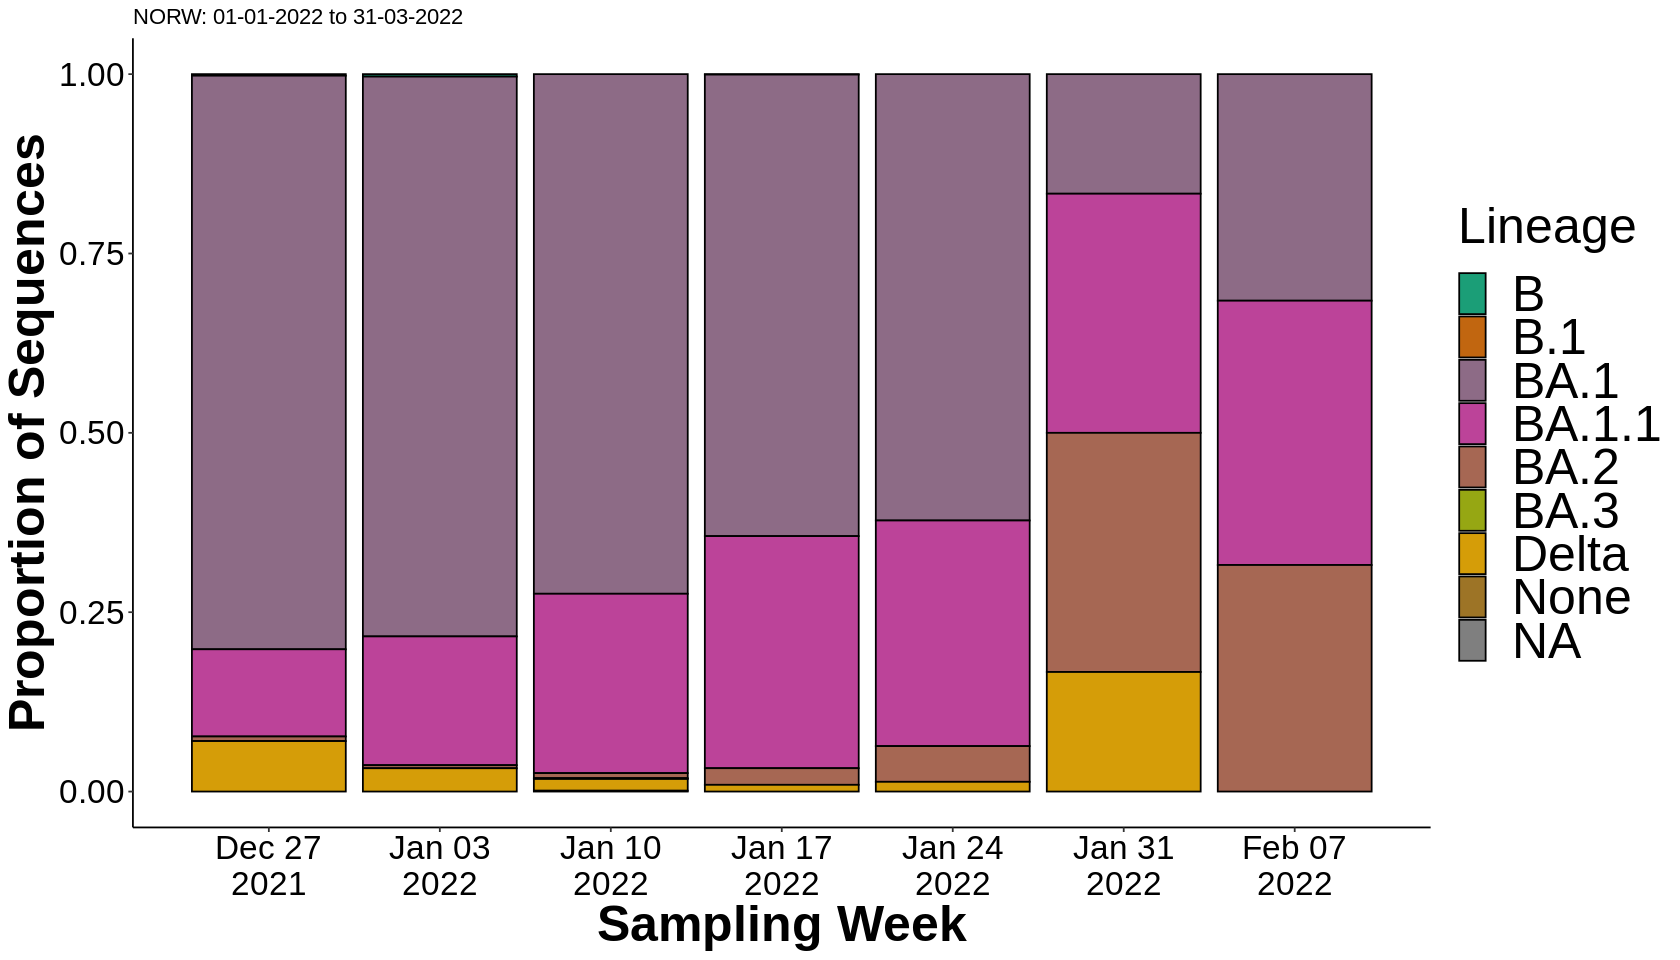

In [11]:
options(repr.plot.width=14, repr.plot.height=8) ; par(oma=c(0,0,0,0))
    
p <- ggplot(meta, aes(x = date2, fill=lineage)) + geom_bar(position='fill', color='black')  ## geom_bar()
p <- p + ggplot2::scale_fill_manual(values=getPal_lineage, name="Lineage")
p <- p + theme_classic() + theme(axis.text.x = element_text(color="black", size=16)) + xlab("Sampling Week") + ylab("Proportion of Sequences")
p <- p + scale_x_date(date_labels = "%b %d\n%Y",date_breaks = "1 week")
p <- p + theme(axis.title.x = element_text(color="black", size=30, face="bold"), 
               axis.text.x = element_text(color="black", size=20),
               axis.title.y = element_text(color="black", size=30, face="bold"),
               axis.text.y = element_text(color="black", size=20),
               legend.text = element_text(size=30), legend.title = element_text(size=30)
              )

p <- p + labs(title = paste0("NORW: 01-01-2022 to 31-03-2022"))
p

**Counts**

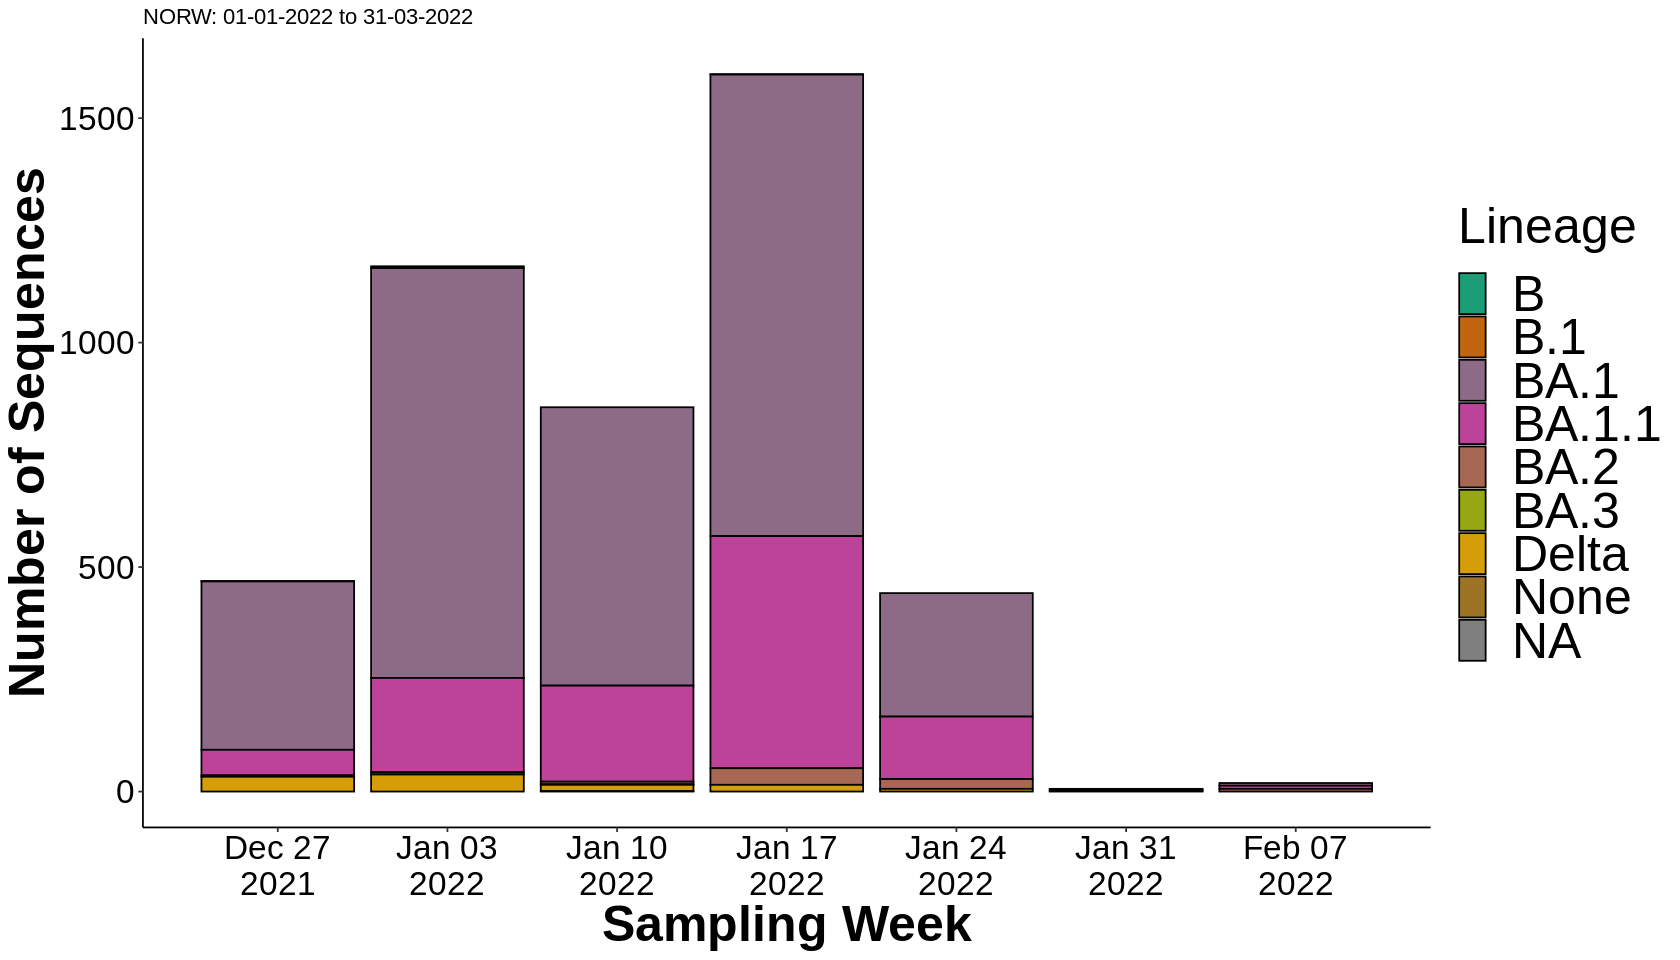

In [12]:
options(repr.plot.width=14, repr.plot.height=8) ; par(oma=c(0,0,0,0))
    
p <- ggplot(meta, aes(x = date2, fill=lineage)) + geom_bar(color='black')  ## geom_bar()
p <- p + ggplot2::scale_fill_manual(values=getPal_lineage, name="Lineage")
p <- p + theme_classic() + theme(axis.text.x = element_text(color="black", size=16)) + xlab("Sampling Week") + ylab("Number of Sequences")
p <- p + scale_x_date(date_labels = "%b %d\n%Y",date_breaks = "1 week")
p <- p + theme(axis.title.x = element_text(color="black", size=30, face="bold"), 
               axis.text.x = element_text(color="black", size=20),
               axis.title.y = element_text(color="black", size=30, face="bold"),
               axis.text.y = element_text(color="black", size=20),
               legend.text = element_text(size=30), legend.title = element_text(size=30)
              )

p <- p + labs(title = paste0("NORW: 01-01-2022 to 31-03-2022"))
p